# Dynamic multilayer LSTM-RNN 

To increase the power of our network we can add several layers of LSTM cells using the *MultiRNNCell* function, resulting in a *deep* recurrent neural network. Further, we will add dropout.

In [1]:
% matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Global configuration parameters
n_epochs = 20
total_series_length = 50000
truncated_backprop_steps = 15
echo_step = 3 # number of steps the input is shifted to the right
batch_size = 5
eta = 0.001 # learning rate
n_batches = total_series_length// batch_size//truncated_backprop_steps

# Network parameters
n_hidden = 10 # number of hidden units in each LSTM layer
n_layers = 3 
inp_drop = 1 # dropout input keep probability
out_drop = 1 # dropout output keep probability
n_classes = 2

## Input data

Up to now, our complete training data had the size (5, 10000). Although we will keep these dimensions and also the dimension of the X_placeholder variabe, we will add another dimension to the input when feeding it into the RNN. Before, the batch size was (5,15), i.e. (batch_size, truncated_backprop_steps). Now, for the dynamic rnn the batch size will be (5,15,1).

In [3]:
def generateData():
    """
    Generates training data. The input data is simply a vector of random
    numbers with n_classes classes. The target output is the input shifted 
    by "echo_steps" steps to the right.
    
    Returns:
        x: numpy array of shape (batch_size,-1) filled with random values
        in the range (n_classes)
        
        y: numpy array of shape (batch_size, -1), x shifted "echo_step" to 
        the right
    """

    x = np.array(np.random.choice(n_classes, total_series_length))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))
    y = y.reshape((batch_size, -1))

    return(x, y)

## Network architecture and forward pass

As mentioned before, the shape of the input batches is now (batch_size, truncated_backprop_steps, input_size). Our X_placeholder variable can stay the same but we will insert a dimension of 1 when feeding it into tf.nn.dynamic_rnn. This is done using the function [tf.expand_dims](https://www.tensorflow.org/api_docs/python/tf/expand_dims)

To create multiple layers we call the MultiRNNCell function that takes a list of RNN cells as an input and wraps them into a single cell. 
To further use dropout with MultiRNNCell we wrap the base LSTM cell with dropout. This ensures that dropout is part of each cell passed into the MultiRNNCell function.

In [4]:
X_placeholder = tf.placeholder(tf.float32, shape=[batch_size, truncated_backprop_steps])
y_placeholder = tf.placeholder(tf.int32, shape=[batch_size, truncated_backprop_steps])

# For each initialized LSTM cell we need to specify how many hidden
# units the cell should have.
cell = tf.contrib.rnn.LSTMCell(num_units=n_hidden)

# Add dropout
cell = tf.contrib.rnn.DropoutWrapper(cell, 
                                     input_keep_prob=inp_drop, 
                                     output_keep_prob=out_drop)

# Create multiple layers using the MultiRNNCell function
cell = tf.contrib.rnn.MultiRNNCell([cell]*n_layers)

# Create a zero-filled state tensor
init_state = cell.zero_state(batch_size, tf.float32)

# Create a recurrent neural network specified by "cell", i.e. unroll the
# network.
# Returns a list of all previous RNN hidden states and the final states.
# final_state is now contains three LSTMStateTuple that contain both the 
# final hidden and the cell state of the respective layer.

outputs, final_state = tf.nn.dynamic_rnn(cell, tf.expand_dims(X_placeholder,-1), initial_state=init_state)

# Reshape the outputs and targets such that the logits can be computed 
# using a single matrix multiplication
temp = tf.reshape(outputs, [-1, n_hidden])
y_temp = tf.reshape(y_placeholder, [-1])

# The output of the network is a one-hot encoded vector of predictions.
# When also transforming the target labels into a one-hot encoding (as done
# below), we have to change the loss computation into 
# "tf.nn.softmax_cross_entropy_with_logits"
#y_temp_one_hot = tf.one_hot(y_temp, n_classes)

V = tf.Variable(tf.random_normal([n_hidden, n_classes]))
c = tf.Variable(tf.random_normal([n_classes]))

logits = tf.matmul(temp,V)+c

## Network output and loss function

The predictions of the RNN and the loss are computed in the same way as before.

In [5]:
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_temp_one_hot,
#                                                              logits=l))

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_temp,
                                                             logits=logits))
optimizer = tf.train.AdamOptimizer(learning_rate=eta).minimize(loss)

## Training

In [6]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    training_losses = []
    
    for epoch in range(n_epochs):
        print("")
        print("Epoch: ", epoch)
        
        X_data, y_data = generateData()
        
        for batch in range(n_batches):
        
            start_idx = batch*truncated_backprop_steps
            end_idx = start_idx+truncated_backprop_steps
            
            batch_x = X_data[:, start_idx:end_idx]
            batch_y = y_data[:, start_idx:end_idx]

            _total_loss, _optimizer = sess.run(
                [loss, optimizer],
                feed_dict={
                    X_placeholder: batch_x,
                    y_placeholder:batch_y})
            
            training_losses.append(_total_loss)
            
            if batch%100 == 0:
                print("Step: ", batch, "Loss: ", _total_loss)


Epoch:  0
Step:  0 Loss:  0.744981
Step:  100 Loss:  0.65726
Step:  200 Loss:  0.625148
Step:  300 Loss:  0.615903
Step:  400 Loss:  0.59988
Step:  500 Loss:  0.561155
Step:  600 Loss:  0.447163

Epoch:  1
Step:  0 Loss:  0.425452
Step:  100 Loss:  0.275871
Step:  200 Loss:  0.207403
Step:  300 Loss:  0.215083
Step:  400 Loss:  0.151715
Step:  500 Loss:  0.1603
Step:  600 Loss:  0.156828

Epoch:  2
Step:  0 Loss:  0.123033
Step:  100 Loss:  0.135289
Step:  200 Loss:  0.147332
Step:  300 Loss:  0.140565
Step:  400 Loss:  0.131583
Step:  500 Loss:  0.139875
Step:  600 Loss:  0.146852

Epoch:  3
Step:  0 Loss:  0.141128
Step:  100 Loss:  0.136378
Step:  200 Loss:  0.13582
Step:  300 Loss:  0.143436
Step:  400 Loss:  0.137239
Step:  500 Loss:  0.139576
Step:  600 Loss:  0.141604

Epoch:  4
Step:  0 Loss:  0.134611
Step:  100 Loss:  0.136236
Step:  200 Loss:  0.135777
Step:  300 Loss:  0.136954
Step:  400 Loss:  0.141906
Step:  500 Loss:  0.13757
Step:  600 Loss:  0.137692

Epoch:  5
Step:

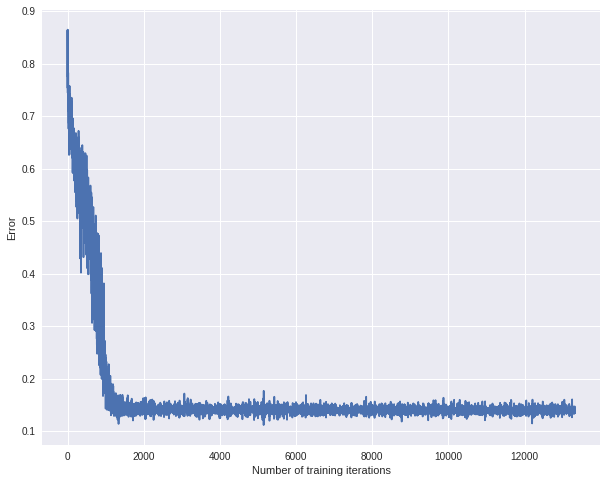

In [7]:
plt.figure(figsize=(10,8));
plt.plot(training_losses);
plt.xlabel('Number of training iterations');
plt.ylabel('Error');